In [ ]:
!apt-get install openjdk-11-jdk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  gsettings-desktop-schemas java-common libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libpcsclite1 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  gsettings-desktop-schemas java-common libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0

In [ ]:
from pyspark.sql import SparkSession

#Crear una sesión de Spark
spark = (SparkSession.builder
    .appName('Regresion Lineal Escalable')
    .master("local[*]")
    .getOrCreate())

spark.sparkContext.setLogLevel('WARN')
print("Spark: "+spark.version)

Spark: 3.5.1


Load Dataset

In [ ]:
from pyspark import SparkFiles

spark.sparkContext.addFile("https://raw.githubusercontent.com/Royland97/dataset/main/SP500.csv")
df = spark.read.csv(SparkFiles.get("SP500.csv"), header=True, inferSchema=True)
df.printSchema()
df.show()

root
 |-- Date: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+-----------+-----------+-----------+-----------+------+
|      Date|      Close|       High|        Low|       Open|Volume|
+----------+-----------+-----------+-----------+-----------+------+
|12/30/1927|17.65999985|17.65999985|17.65999985|17.65999985|     0|
|  1/3/1928|17.76000023|17.76000023|17.76000023|17.76000023|     0|
|  1/4/1928|17.71999931|17.71999931|17.71999931|17.71999931|     0|
|  1/5/1928|17.54999924|17.54999924|17.54999924|17.54999924|     0|
|  1/6/1928|17.65999985|17.65999985|17.65999985|17.65999985|     0|
|  1/9/1928|       17.5|       17.5|       17.5|       17.5|     0|
| 1/10/1928|17.37000084|17.37000084|17.37000084|17.37000084|     0|
| 1/11/1928|17.35000038|17.35000038|17.35000038|17.35000038|     0|
| 1/12/1928|17.46999931|17.469

In [ ]:
df.describe().show()

+-------+---------+------------------+-----------------+------------------+------------------+--------------------+
|summary|     Date|             Close|             High|               Low|              Open|              Volume|
+-------+---------+------------------+-----------------+------------------+------------------+--------------------+
|  count|    24532|             24532|            24532|             24532|             24532|               24532|
|   mean|     NULL| 694.0001633637921|697.8785673100726| 689.5704867369452| 693.8475162857003|  9.47004829202674E8|
| stddev|     NULL|1165.4443305313214|1171.510658987005|1158.4457212068005|1165.1973868558123|1.6589181737736232E9|
|    min|1/10/1928|       4.400000095|      4.400000095|       4.400000095|       4.400000095|                   0|
|    max| 9/9/2024|       6501.859863|       6508.22998|       6466.959961|       6489.279785|         11456230000|
+-------+---------+------------------+-----------------+----------------

Selección de características

In [ ]:
rdd_close = df.select('Close').rdd.map(lambda row: row["Close"])
rdd_close.take(5)

[17.65999985, 17.76000023, 17.71999931, 17.54999924, 17.65999985]

#Regresión lineal escalable por solución de forma cerrada

Transformacion

In [ ]:
import numpy as np

#Cantidad de valores previos a usar
n_val=5

def create_xy(seq, n_val):
    data = []
    for i in range(n_val, len(seq)):
        X = seq[i - n_val:i] # 5 valores previos
        y = seq[i]            # valor actual
        data.append((np.array(X), y))
    return data

rdd_data = spark.sparkContext.parallelize(create_xy(rdd_close.collect(), n_val))
rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=1234)

Escalabilidad con MapReduce

In [ ]:
# Calculo 𝑋t𝑋 y Xty
XtX_sum, Xty_sum = rdd_train.map(lambda row: (
    np.outer(np.r_[1, row[0]], np.r_[1, row[0]]),  # XᵀX parcial
    np.r_[1, row[0]] * row[1]                      # Xᵀy parcial
)).reduce(
    lambda a, b: (a[0] + b[0], a[1] + b[1])        # Reducimos sumando las matrices y vectores
)

In [ ]:
theta = np.linalg.inv(XtX_sum) @ Xty_sum
print("Parámetros θ:", theta)

Parámetros θ: [-0.08065524  0.04360135 -0.04248305 -0.03812427  0.09029666  0.94734273]


Predicción

In [ ]:
last_row = rdd_test.collect()[-1]

# Extraer los últimos 5 valores (X) y el valor real (y)
last_5 = last_row[0]
y_real = last_row[1]

# Predicción
x_new_b = np.r_[1, np.array(last_5)]
y_pred = float(x_new_b @ theta)

# Mostrar resultados
print("Últimos 5 valores close del test:", last_5)
print("Valor real siguiente (y):", y_real)
print(f"Predicción siguiente close: {y_pred:.4f}")

Últimos 5 valores close del test: [6466.910156 6439.319824 6465.939941 6481.399902 6501.859863]
Valor real siguiente (y): 6460.259766
Predicción siguiente close: 6506.5525


Evaluacion del modelo

In [ ]:
def cost_function(rdd_data, theta):
    m = rdd_data.count()

    # Calcular suma de los cuadrados de los errores
    sum_squared_errors = rdd_data.map(lambda row: (
        (np.r_[1, row[0]] @ theta - row[1]) ** 2
    )).sum()

    # Calcular J(θ)
    J = sum_squared_errors / (2 * m)
    return J

In [ ]:
# Evaluar función de costo en train y test
J_train = cost_function(rdd_train, theta)
J_test = cost_function(rdd_test, theta)

print(f"Función de costo en train: {J_train:.6f}")
print(f"Función de costo en test: {J_test:.6f}")

Función de costo en train: 103.512039
Función de costo en test: 131.556793


Visualizar resultados

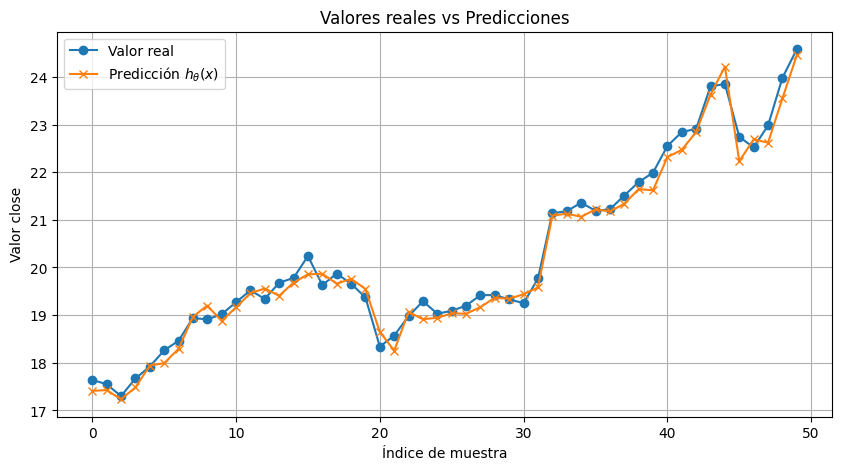

In [ ]:
import matplotlib.pyplot as plt

sample_rdd = spark.sparkContext.parallelize(rdd_test.take(50))

# Obtener pares (índice, (y_real, y_pred))
real_pred_rdd = sample_rdd.zipWithIndex().map(lambda x: (
    x[1],  # índice
    (x[0][1], float(np.r_[1, x[0][0]] @ theta))  # (real, predicción)
))

# Traer al driver
real_pred = real_pred_rdd.collect()

# Separar índices, valores reales y predicciones
indices = [x[0] for x in real_pred]
y_real = [x[1][0] for x in real_pred]
y_pred = [x[1][1] for x in real_pred]

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(indices, y_real, label='Valor real', marker='o')
plt.plot(indices, y_pred, label='Predicción $h_\\theta(x)$', marker='x')
plt.title('Valores reales vs Predicciones')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor close')
plt.legend()
plt.grid(True)
plt.show()


#Regresion lineal escalable por descenso del gradiente

Normalizacion

In [ ]:
min_value = rdd_close.reduce(lambda a, b: a if a < b else b)
max_value = rdd_close.reduce(lambda a, b: a if a > b else b)

rdd_norm = rdd_close.map(lambda x: (x - min_value) / (max_value - min_value))
rdd_norm.take(5)

[0.002040797486215095,
 0.0020561881745933207,
 0.0020500317810419927,
 0.0020238676994490373,
 0.002040797486215095]

Transformacion

In [ ]:
import numpy as np

#Cantidad de valores previos a usar
n_val=5

def create_xy(seq, n_val):
    data = []
    for i in range(n_val, len(seq)):
        X = seq[i - n_val:i] # 5 valores previos
        y = seq[i]            # valor actual
        data.append((np.array(X), y))
    return data

rdd_data_norm = spark.sparkContext.parallelize(create_xy(rdd_norm.collect(), n_val))
rdd_train_norm, rdd_test_norm = rdd_data_norm.randomSplit([0.8, 0.2], seed=1234)

Escalabilidad con MapReduce

In [ ]:
import numpy as np

def gradient_descent_parallel(rdd, alpha=0.01, num_iters=1000, tol=1e-6):
    m = rdd.count()
    n = len(rdd.first()[0])

    # Cachear los datos para acelerar accesos repetidos
    rdd_cached = rdd.cache()

    theta = np.zeros(n + 1)  # Inicializar theta

    for iteration in range(num_iters):
        # Compartir theta con los workers para evitar enviar mucho en cada llamada
        theta_broadcast = spark.sparkContext.broadcast(theta)

        # Map: calcular (h_theta(x) - y) * x vector para cada muestra
        gradient_sum = rdd_cached.map(lambda xy: (
            np.r_[1, xy[0]] * (np.dot(theta_broadcast.value, np.r_[1, xy[0]]) - xy[1])
        )).reduce(lambda a, b: a + b)

        # Gradiente promedio
        gradient = gradient_sum / m

        # Actualizar theta
        theta_new = theta - alpha * gradient

        # Calcular diferencia para criterio de parada
        diff = np.linalg.norm(theta_new - theta)
        theta = theta_new

        # Liberar la variable broadcast para la siguiente iteración
        theta_broadcast.unpersist()

        cost = rdd_cached.map(lambda xy: ((np.dot(theta, np.r_[1, xy[0]]) - xy[1]) ** 2)).sum() / (2*m)

        if iteration == 0:
            print(f"Gradiente inicial: {gradient}")
            print(f"Costo inicial: {cost}")

        if iteration % 100 == 0 or diff < tol:
            print(f"Iteración {iteration}: Costo = {cost:.6f}, cambio theta = {diff:.8f}")

        if diff < tol:
            print(f"Convergencia alcanzada en iteración {iteration}.")
            break

    return theta

In [ ]:
theta_gd = gradient_descent_parallel(rdd_train_norm, alpha=0.01, num_iters=100)
print("Theta estimado por descenso por gradiente:", theta_gd)

Gradiente inicial: [-0.10634928 -0.04311955 -0.04314892 -0.04316953 -0.04319737 -0.04320738]
Costo inicial: 0.021413416819489568
Iteración 0: Costo = 0.021413, cambio theta = 0.00143624
Theta estimado por descenso por gradiente: [0.06018031 0.03525849 0.03528336 0.03530079 0.03532432 0.03533293]


Prediccion

In [ ]:
last_row = rdd_test_norm.collect()[-1]

# Extraer los últimos 5 valores (X) y el valor real (y)
last_5 = last_row[0]
y_real_norm = last_row[1]

# Predicción
x_new_b = np.r_[1, np.array(last_5)]
y_pred_norm = float(x_new_b @ theta)

# y_real_real = y_real_norm * (min_value - max_value) + max_value
# y_pred_real = y_pred_norm * (min_value - max_value) + max_value

# Mostrar resultados
print("Últimos 5 valores close del test:", last_5)
print("Valor real siguiente (y):", y_real_norm)
print(f"Predicción siguiente close: {y_pred_norm:.4f}")

Últimos 5 valores close del test: [0.99462102 0.99037469 0.9944717  0.99685108 1.        ]
Valor real siguiente (y): 0.9935974830352549
Predicción siguiente close: 0.9201


Evaluar modelo

In [109]:
def cost_function(rdd_data, theta):
    m = rdd_data.count()

    # Calcular suma de los cuadrados de los errores
    sum_squared_errors = rdd_data.map(lambda row: (
        (np.r_[1, row[0]] @ theta - row[1]) ** 2
    )).sum()

    # Calcular J(θ)
    J = sum_squared_errors / (2 * m)
    return J

In [111]:
# Evaluar función de costo en train y test
J_train = cost_function(rdd_train_norm, theta_gd)
J_test = cost_function(rdd_test_norm, theta_gd)

print(f"Función de costo en train: {J_train:.6f}")
print(f"Función de costo en test: {J_test:.6f}")

Función de costo en train: 0.011210
Función de costo en test: 0.011615
